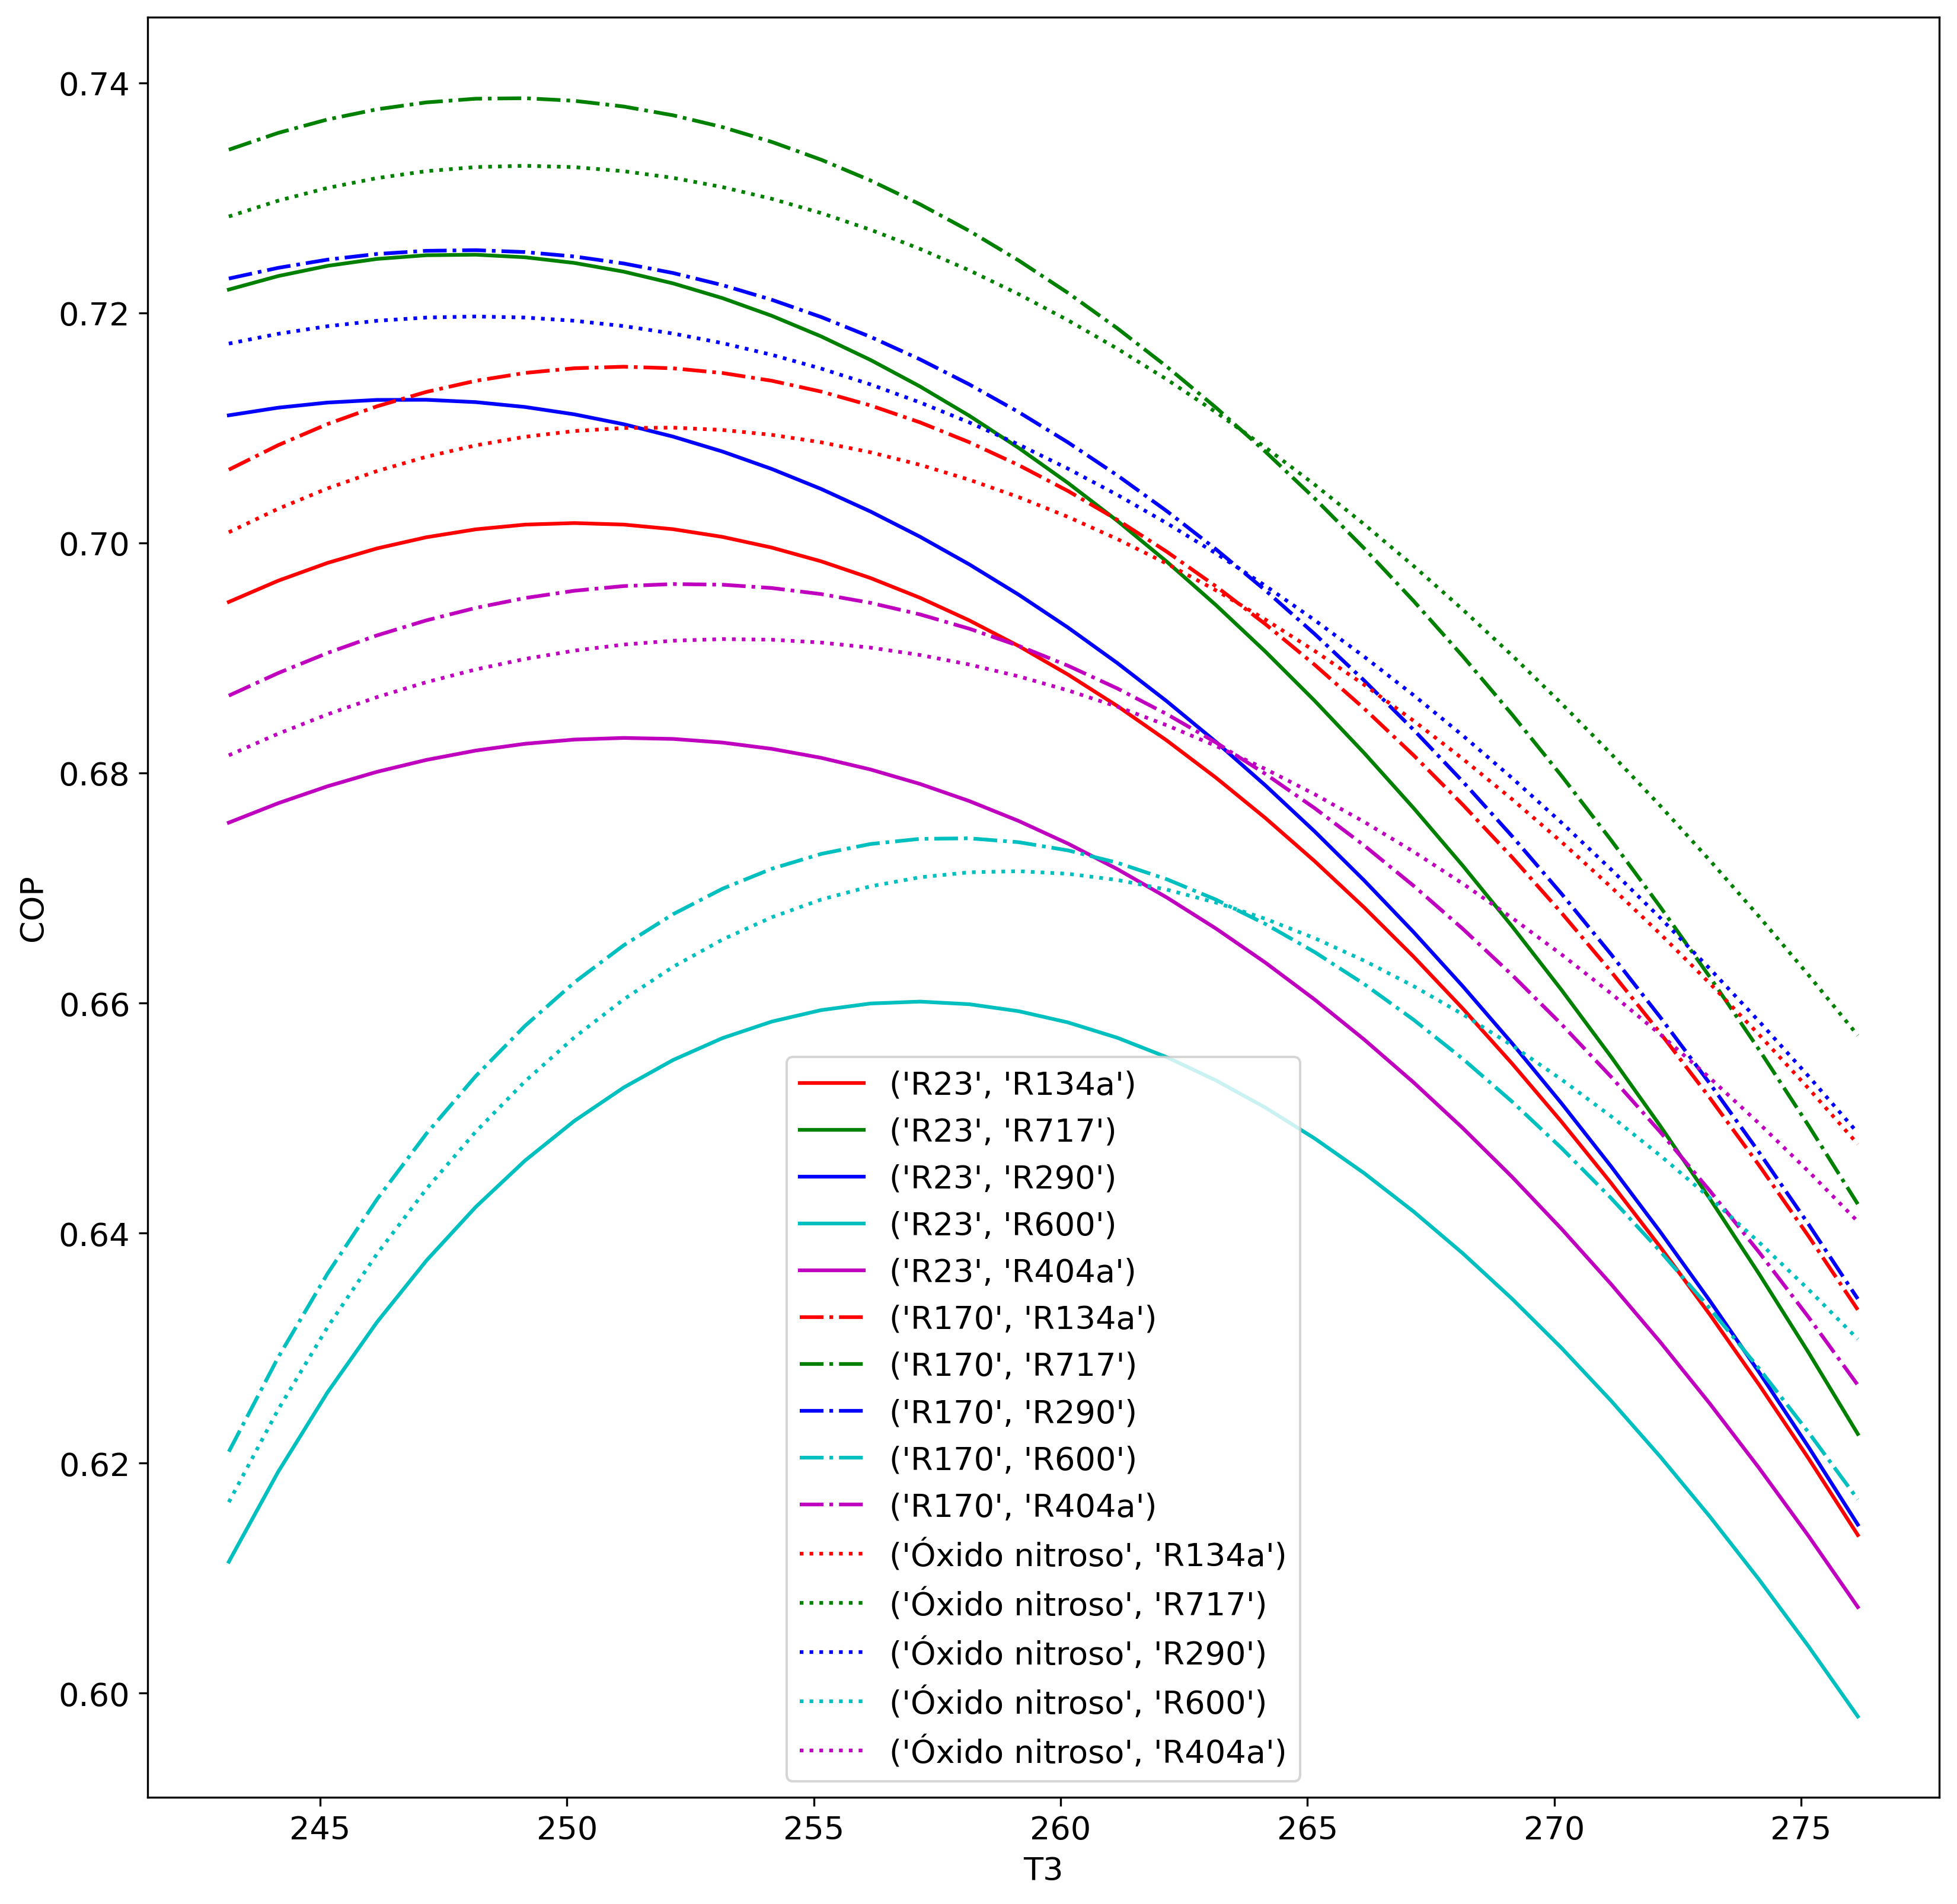

In [2]:
#Bibliotecas
from CoolProp.CoolProp import PropsSI as COOLPROP
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data


#Listas
registro_fluidos = []
COP_lista = []
lista_T3 = []
Wcomp_total_lista = []
cont = []

#Lista de Temperaturas
for T3 in range (-3000 + 27315, 400 + 27315, 100):
    T3 = T3 / 100
    cont.append(T3)

#Características para as curvas do gráfico
lista_cor = ['r','g','b', 'c', 'm']
lista_ls = ['-', '-.', ':']
caracteristicas = []
for ls in lista_ls:
    for cor in lista_cor:
        caracteristicas.append((cor, ls))

#Parâmetros
Pfrig = 120 * 1000 #[W]
T1 = -80 + 273.15 #[K]
T7 = 28 + 273.15 #[K]
N = 0.7 #Eficiência isentrópica
fluid_high_lista = ['R134a', 'R717', 'R290', 'R600', 'R404a']
fluid_low_lista = ['R23', 'R170', 'NitrousOxide']
drop_suc = 12000 #[Pa]
drop_desc = 24000 #[Pa]
DeltaT = 4 #[°C]

#Variação dos refrigerantes e do da Pressão de saída do compressor
for fluid_low in fluid_low_lista:
    for fluid_high in fluid_high_lista:      
        if fluid_low == 'NitrousOxide':
            par_fluido = ('Óxido nitroso', fluid_high)    
        else:
            par_fluido = (fluid_low, fluid_high)
        registro_fluidos.append(par_fluido)
         #Temperatura T3
        for T3 in cont:
            P1 = COOLPROP('P', 'T', T1, 'Q', 1, fluid_low) 
            h1 = COOLPROP('H', 'T', T1, 'Q', 1, fluid_low)
            ha = h1
            Pa = P1 - drop_suc
            Ta = COOLPROP('T', 'H', ha, 'P', Pa, fluid_low)
            Pb = Pa
            Tb = Ta + DeltaT
            hb = COOLPROP('H', 'T', Tb, 'P', Pb, fluid_low)
            Sb = COOLPROP('S', 'T', Tb, 'P', Pb, fluid_low)
            P3 = COOLPROP('P', 'T', T3, 'Q', 0 , fluid_low)
            P2 = P3
    
            Pc = P2 + drop_desc
            Sc_ideal = Sb     
            hc_ideal = COOLPROP('H', 'S', Sc_ideal , 'P', Pc, fluid_low)
            hc_real = (hc_ideal - hb)/N + hb
            h2 = hc_real

            h3 = COOLPROP('H', 'T', T3, 'Q', 0, fluid_low)
            h4 = h3
            m_flow_low = Pfrig / (h1 - h4)
        
            w_low = hc_real - hb
            Wcomp_low = m_flow_low * w_low

            #Pressão crítica do fluido do ciclo de alta pressão
            P_crit_high = COOLPROP('PCRIT', fluid_high)
            #Ciclo de alta pressão
            h7 = COOLPROP('H', 'T', T7, 'Q', 0, fluid_high)
            P7 = COOLPROP('P', 'T', T7, 'Q', 0, fluid_high)

            T8 = T3 - 5
            h8 = h7
            #Q<>0, mas como o refrigerante se encontra em uma fase saturada a pressão é a mesma para qualquer Q com T=T8
            P8 = COOLPROP('P', 'Q', 0, 'T', T8, fluid_high) 
            P5 = P8
            h5 = COOLPROP('H', 'P', P5, 'Q', 1, fluid_high)
            T5 = COOLPROP('T', 'P', P5, 'Q', 1, fluid_high)           
            hw = h5
            Pw = P5 - drop_suc
            Tw = COOLPROP('T', 'H', hw, 'P', Pw, fluid_high)
            Px = Pw
            Tx = Tw + DeltaT
            hx = COOLPROP('H', 'P', Px, 'T', Tx, fluid_high)
            sx = COOLPROP('S', 'P', Px, 'T', Tx, fluid_high)
            
            P6 = P7
            Py = P6 + drop_desc
            sy_ideal = sx
            hy_ideal = COOLPROP('H', 'P', Py, 'S', sy_ideal, fluid_high)
            hy_real = (hy_ideal - hx)/N + hx
            
            #Calor trocado no trocador central
            Qcond_low =  m_flow_low * (h2 - h3)
            #Ciclo superior
            Qevap_high = Qcond_low
            m_flow_high = Qevap_high / (h5 - h8)
            w_high = hy_real - hx
            Wcomp_high = m_flow_high * w_high
            
            Wcomp_total = Wcomp_low + Wcomp_high
            
            if P_crit_high > P6:
                lista_T3.append(T3)
                Wcomp_total_lista.append(Wcomp_total / 1000)
                #COP
                COP = Pfrig / Wcomp_total
                COP_lista.append(COP)  
            else:
                print ('A pressão P6 = {:0.2f} kPa (T3 = {}, fluido inf = {}, fluido sup = {}) é maior do que a ' 
                'pressão crítica do {} logo o ponto não foi incluído no gráfico'.format(P6 / 1000,T3,fluid_low,
                                                                                               fluid_high, fluid_high))



    
    
if len(lista_T3) != 0:
    plt.rc('xtick', labelsize = 13)
    plt.rc('ytick', labelsize = 13)
    plt.figure(figsize = [13, 13], dpi = 300)
    for i in range (0, len(COP_lista), len(cont)):
        eixo_x = []
        eixo_y = []
        for j in range (i, i + len(cont), 1):
            eixo_x.append(lista_T3[j])
            eixo_y.append(COP_lista[j])
        plt.plot(eixo_x, eixo_y, color = caracteristicas[int(i/len(cont))][0], 
                 linestyle = caracteristicas [int(i/len(cont))][1], 
                 label=registro_fluidos[int(i/len(cont))])
        plt.xlabel('T3', size = 13)
        plt.ylabel('COP', size = 13)
    plt.legend(prop={'size' : 13})
    plt.show()
else:
    print('Todos os pontos são inválidos')

